### Yolo setup through opencv



In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

paths

In [46]:
imgpath = r"C:\Users\Ale\PYEnv\env\JupyterLab\BionicSensesYolo\data\eagle.jpg"

actual code

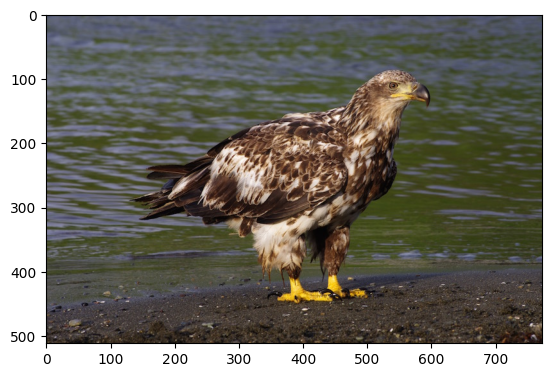

In [47]:
img = cv2.imread(imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### explore classes of coco dataset. choose everyday objects

In [9]:
import os
classpath = os.getcwd()[:-7]+ "cfg\coco.names"

with open(path,"r") as file: #80 classes
    x =len(file.readlines())
    print("n classes: ",x)
          
#everyday objects chosen:backpack, umbrella, handbag , suitcase, bottle, wine glass , cup,fork knife
#spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake laptop cell phone microwave scissors
#toothbrush

n classes:  80


### prepare to run Yolo
- blobFromImage perform mean subtraction and scaling [link](https://pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/)
- images size is dependent on acquisition, but it's fixed
- [route] layer in cfg is like resnet see this [link](https://nico-curti.github.io/NumPyNet/NumPyNet/layers/route_layer.html)
- [YOLO] layers are the out layers. see this [link](https://nico-curti.github.io/NumPyNet/NumPyNet/layers/yolo_layer.html)
- in cfg file, you don't have to specify "input=namelayer" bc it is assumed input = output of previous layer. in the case of [yolo] layers,
- the param "anchors" is a list of couple of integers describing the width-height of the anchors boxes (9 in total)
- the "mask" param specify which of the anchors boxes to use.
- Yolo requires specific input size-> bc it is trained on CNN with specific filtersize -> input has to be of that size. Yolo takes care of keeping aspect ratio. Anyway final result works on initial image

#### input layer

In [61]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

#testing
imgpath = r"C:\Users\Ale\PYEnv\env\JupyterLab\BionicSensesYolo\data\WarzoneSample1.jpg"
img = cv2.imread(imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

classpath = os.getcwd()[:-7]+ "cfg\coco.names"
cfgpath = os.getcwd()[:-7]+ "cfg"
datapath = os.getcwd()[:-7]+"data"
weightspath = cfgpath + "\yolov4.weights"
confignet = cfgpath+"\yolov4.cfg"

Width = img.shape[1]
Height = img.shape[0]
print("input image shape is: ",img.shape)
scale = 0.00392
classes = None
with open(classpath, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# only for testing. 80x3x255 -> rgb
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet(weightspath, confignet)

# create input blob. 3rd arg is size that yolo network expects.4th mean to subtract.5th swarp RGB
#WATCH OUT fot 3rd argument -> if one of standard, it throws different error
#Yolo keeps aspect ratio, i.e. image 1280x720 will be resized to 416x234, and then will be inserted into 416x416 network.
blob = cv2.dnn.blobFromImage(img, scale, (416,416), (0,0,0), True, crop=False)
print("Blob shape is: ",blob.shape)
#blob = np.squeeze(blob)

#to visualize. no idea why returns so many img
blobb = blob.reshape(blob.shape[2],blob.shape[3],blob.shape[1])
print("BLOBB shape is: ",blobb.shape)
cv2.imshow("blob",blobb[:][:][:])
cv2.waitKey()
cv2.destroyAllWindows()

print("blob type is: ",type(blob))

# set input blob for the network
net.setInput(blob)

input image shape is:  (1440, 2560, 3)
Blob shape is:  (1, 3, 416, 416)
BLOBB shape is:  (416, 416, 3)
blob type is:  <class 'numpy.ndarray'>


#### output layer

In [37]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    #yolov3 has 3 uoutlayers. yolov4
    x = net.getUnconnectedOutLayers()
    print("return unconn is: ",type(x)) #ndarray
    print("return is: ",x) #[327 353 379]
    print("unconneted layers name are: ",[layer_names[i- 1] for i in net.getUnconnectedOutLayers()])
    output_layers = [layer_names[i- 1] for i in net.getUnconnectedOutLayers()]
    print("random name of a layer is: ", net.getLayerNames()[0])

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]
                        #(startpoint),(endpoint)
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

### Inference

In [49]:
# run inference through the network
# and gather predictions from output layers.specifying the name allow it to return the output of those layers
outs = net.forward(get_output_layers(net))

# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

# for each detetion from each output layer 
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:                       #one out is a dimxdimx(255= B*(classes+5=attributes of boundbox))
    for detection in out:              #3 outputs per image, each out 3 bounding boxes(?)
        scores = detection[5:]         #scores of the classes
        class_id = np.argmax(scores)   #most likely class
        confidence = scores[class_id]  #likelyhood of that one
        if confidence > 0.5:
            #see paper -> 0<coords<1
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

return unconn is:  <class 'numpy.ndarray'>
return is:  [327 353 379]
unconneted layers name are:  ['yolo_139', 'yolo_150', 'yolo_161']
random name of a layer is:  conv_0


### Nonmax Suppression

In [50]:
# apply non-max suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

# go through the detections remaining
# after nms and draw bounding box
for i in indices:
    i = i
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    draw_bounding_box(img, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

# display output image    
cv2.imshow("object detection", img)

# wait until any key is pressed
cv2.waitKey()
    
 # save output image to disk
cv2.imwrite(datapath+"\object-detection.jpg", img)

# release resources
cv2.destroyAllWindows()